## $\textbf{Imports}$

In [128]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
import time
import numpy
import numba

##  $\textbf{Navier Stokes Equation}$

## $\textbf{Pure python}$

In [129]:
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
    
    row, col = p.shape
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b


def pressure_poisson_pure(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]
        p[:, 0] = p[:, 1]
        p[-1, :] = 0
        
    return p

def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    pn = np.empty_like(p)
    pn = p.copy()
    
    for n_nt in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b_pure(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson_pure(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

## $\textbf{Numba Accelerator}$

In [130]:
@numba.njit(fastmath=True)
def build_up_b_numba(b, rho, dt, u, v, dx, dy):
    
    row, col = p.shape
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b

@numba.njit(fastmath=True)
def pressure_poisson_numba(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]
        p[:, 0] = p[:, 1]
        p[-1, :] = 0
        
    return p

@numba.njit(fastmath=True)
def cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    pn = np.empty_like(p)
    pn = p.copy()
    
    for n_nt in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b_numba(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson_numba(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

## $\textbf{ Pyccel Accelerator}$

In [131]:
def cavity_flow_pyccel(nt:'int', u:'float[:,:]',un:'float[:,:]', v:'float[:,:]',vn:'float[:,:]',b:'float[:,:]',
                       dt:'float', nx:'int', ny:'int', dx:'float', dy:'float', p:'float[:,:]',pn:'float[:,:]', rho:'int', nu:'float',nit:'int'):
    
    for i in range(ny):
        for j in range(nx):
            b[i, j] = 0
            un[i, j] = u[i, j]
            vn[i, j] = v[i, j]
            pn[i, j] = p[i, j]
                   
           
    for n in range(nt):
        un[:,:] = u[:, :]
        vn[:,:] = v[:, :]
        
    row, col = p.shape
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))  
    
    pn[:,:] = p[:,:]
    
    for q in range(nit):
        pn[:,:] = p[:,:]
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]
        p[:, 0] = p[:, 1]
        p[-1, :] = 0
        
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0


## $\textbf{Inputs}$

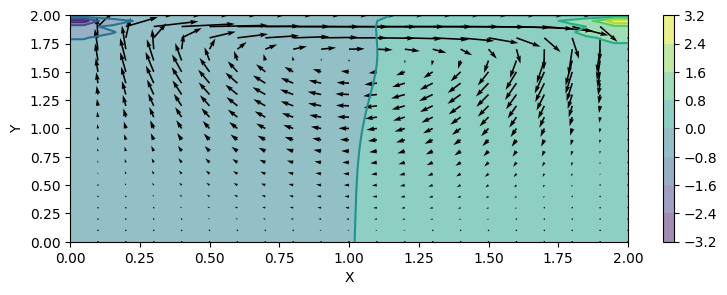

In [132]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p = cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(9, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y')
pyplot.show()

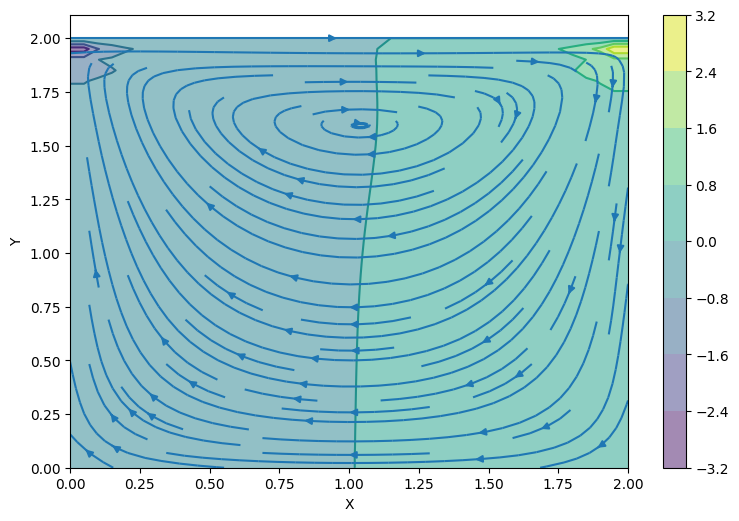

In [133]:
fig = pyplot.figure(figsize=(9, 6), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y')
pyplot.show()

## $\textbf{Call Funtions}$

## $\textbf{Pure python function}$

In [134]:
%timeit cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

814 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## $\textbf{Numba python function}$

In [135]:
%timeit cavity_flow_numba(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

325 ms ± 8.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## $\textbf{Pyccel Accelerator}$

In [137]:
from pyccel.epyccel import epyccel

In [138]:
cavity_flow_pyccel_f90 = epyccel(cavity_flow_pyccel)

In [139]:
%timeit cavity_flow_pyccel_f90

18.8 ns ± 0.231 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


$\textbf{Numba accelerator implementation runs faster than pure function implementation. Pyccel implementation does much better.}$